In [325]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib
import matplotlib.pyplot as plt
import warnings

from IPython.display import Image
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split, validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor

%matplotlib inline

In [326]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.dpi'] = 200
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 6}
matplotlib.rc('font', **font)

In [327]:
df = pd.read_csv('cleaned_no_outliers.csv')

In [328]:
df

,Job Name,Salary,Job Description,Rating,Job Location,Company Size,Year Founded,Company Type,Company Industry,Company Revenue,...,Spark,Tableau,Scala,Big Data,Data Visualization,Description Length,Job Level,Job Label,FAANG Or Not,Grouped Company Industry
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,"Albuquerque, NM",501 to 1000 Employees,1973,Company - Private,Aerospace & Defense,$50 to $100 million (USD),...,0,1,0,0,1,2536,Other,Data Scientist,Not FAANG,Government
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,"Linthicum, MD",10000+ Employees,1984,Other,Health Care Services & Hospitals,$2 to $5 billion (USD),...,0,0,0,0,1,4783,Other,Data Scientist,Not FAANG,Health
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,"Clearwater, FL",501 to 1000 Employees,2010,Company - Private,Security Services,$100 to $500 million (USD),...,1,0,0,1,1,3461,Other,Data Scientist,Not FAANG,Service
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,"Richland, WA",1001 to 5000 Employees,1965,Other,Energy,$500 million to $1 billion (USD),...,0,0,0,0,0,3883,Other,Data Scientist,Not FAANG,Energy & Transportation
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,"New York, NY",51 to 200 Employees,1998,Company - Private,Advertising & Marketing,Unknown / Non-Applicable,...,0,0,0,0,0,2728,Other,Data Scientist,Not FAANG,Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4425,Staff Data Scientist - AI Ethics & ESG,$65K - $128K (Glassdoor est.),Your Job\nAs a member of the AI Ethics team at...,4.4,"Austin, TX",10000+ Employees,2004,Company - Private,Internet & Web Services,$2 to $5 billion (USD),...,1,0,1,1,0,7178,Other,Data Scientist,Not FAANG,Technology
4426,"Data Scientist, Marketing & Online (Remote)",$65K - $128K (Glassdoor est.),The Home Depot is able to offer virtual employ...,3.8,"Atlanta, GA",10000+ Employees,1978,Company - Public,Home Furniture & Housewares Stores,$10+ billion (USD),...,0,1,0,0,1,6183,Other,Data Scientist,Not FAANG,Retail
4427,Principal Data Scientist - Match Recommendations,$65K - $128K (Glassdoor est.),Your Job\nThe Match Recommendations team build...,4.4,"San Francisco, CA",10000+ Employees,2004,Company - Private,Internet & Web Services,$2 to $5 billion (USD),...,1,0,1,0,0,6202,Experienced,Data Scientist,Not FAANG,Technology
4428,"Data Scientist, Remote/Home Based Worker",$65K - $128K (Glassdoor est.),"The world isn’t standing still, and neither is...",3.5,"Northbrook, IL",10000+ Employees,1931,Company - Public,Insurance Agencies & Brokerages,$10+ billion (USD),...,0,0,0,0,0,7719,Other,Data Scientist,Not FAANG,Finance


In [329]:
df.head()

,Job Name,Salary,Job Description,Rating,Job Location,Company Size,Year Founded,Company Type,Company Industry,Company Revenue,...,Spark,Tableau,Scala,Big Data,Data Visualization,Description Length,Job Level,Job Label,FAANG Or Not,Grouped Company Industry
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,"Albuquerque, NM",501 to 1000 Employees,1973,Company - Private,Aerospace & Defense,$50 to $100 million (USD),...,0,1,0,0,1,2536,Other,Data Scientist,Not FAANG,Government
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,"Linthicum, MD",10000+ Employees,1984,Other,Health Care Services & Hospitals,$2 to $5 billion (USD),...,0,0,0,0,1,4783,Other,Data Scientist,Not FAANG,Health
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,"Clearwater, FL",501 to 1000 Employees,2010,Company - Private,Security Services,$100 to $500 million (USD),...,1,0,0,1,1,3461,Other,Data Scientist,Not FAANG,Service
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,"Richland, WA",1001 to 5000 Employees,1965,Other,Energy,$500 million to $1 billion (USD),...,0,0,0,0,0,3883,Other,Data Scientist,Not FAANG,Energy & Transportation
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,"New York, NY",51 to 200 Employees,1998,Company - Private,Advertising & Marketing,Unknown / Non-Applicable,...,0,0,0,0,0,2728,Other,Data Scientist,Not FAANG,Service


In [330]:
columns = ['Rating', 'Company Size', 'Company Type', 'Company Revenue', 'Hourly', 'Employer Provided', 'Glassdoor Estimated', 'Average Salary', 'Job State', 'Company Age', 'Education Demanded', 'Python', 'SQL',
'Excel', 'AWS', 'Spark', 'Tableau', 'Scala', 'Big Data',
'Data Visualization', 'Description Length', 'Job Level', 'Job Label',
 'Grouped Company Industry']

In [331]:
df_model = df[columns]

In [332]:
df.shape

(4430, 33)

# One Hot Encoding

In [333]:
# One Hot Encoding handle unknown is for model to understand what to do with features that are present in the test data sets that are not present in training data sets. In such cases, can ignore, throw error.

# From data cleaning and exploratory data analysis, most of the data is not normalized, and response variable average salary is hard to normalize (trying log, sqrt, inverse). Also complicates interpratability of data.
# Random forest approach would be better suited than linear regressions in this case.
# Also random forest approach means scaling is not necessary. Since we have different features of different scales, we can bypass a scaling step as well.

In [334]:
def split_data(df):
    '''
    Returns data split into training and testing data.
    '''
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Average Salary']), df['Average Salary'], test_size=0.25, random_state=89)

    return X_train, X_test, y_train, y_test

In [335]:
def one_hot_encode_data(X_train, X_test):
    '''
    One hot encodes training and testing data. Fit / transforms training data and then encodes testing data. Ignores unknowns.
    '''
    X_train_cat = X_train.select_dtypes('object')
    X_train_num = X_train.select_dtypes('number')

    ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
    transformed_train = ohe.fit_transform(X_train_cat).toarray()
    # transformed_data.shape
    # ohe.get_feature_names_out().shape
    X_train_cat_transformed = pd.DataFrame(transformed_train, columns=ohe.get_feature_names_out())

    X_train_encoded = pd.concat([X_train_cat_transformed.reset_index(drop=True), X_train_num.reset_index(drop=True)], axis=1)

    X_test_cat = X_test.select_dtypes('object')
    X_test_num = X_test.select_dtypes('number')
    transformed_test = ohe.transform(X_test_cat).toarray()
    X_test_cat_transformed = pd.DataFrame(transformed_test, columns=ohe.get_feature_names_out())
    X_test_encoded = pd.concat([X_test_cat_transformed.reset_index(drop=True), X_test_num.reset_index(drop=True)], axis=1)

    return X_train_encoded, X_test_encoded

In [336]:
X_train, X_test, y_train, y_test = split_data(df_model)
print('Train cols: ', X_train.columns)
print('Test cols: ', X_test.columns)

Train cols:  Index(['Rating', 'Company Size', 'Company Type', 'Company Revenue', 'Hourly',
       'Employer Provided', 'Glassdoor Estimated', 'Job State', 'Company Age',
       'Education Demanded', 'Python', 'SQL', 'Excel', 'AWS', 'Spark',
       'Tableau', 'Scala', 'Big Data', 'Data Visualization',
       'Description Length', 'Job Level', 'Job Label',
       'Grouped Company Industry'],
      dtype='object')
Test cols:  Index(['Rating', 'Company Size', 'Company Type', 'Company Revenue', 'Hourly',
       'Employer Provided', 'Glassdoor Estimated', 'Job State', 'Company Age',
       'Education Demanded', 'Python', 'SQL', 'Excel', 'AWS', 'Spark',
       'Tableau', 'Scala', 'Big Data', 'Data Visualization',
       'Description Length', 'Job Level', 'Job Label',
       'Grouped Company Industry'],
      dtype='object')


In [337]:
X_train_encoded, X_test_encoded = one_hot_encode_data(X_train, X_test)

In [338]:
X_train_encoded.head()

,Company Size_10000+ Employees,Company Size_1001 to 5000 Employees,Company Size_201 to 500 Employees,Company Size_5001 to 10000 Employees,Company Size_501 to 1000 Employees,Company Size_51 to 200 Employees,Company Size_Unknown,Company Type_Company - Public,Company Type_Other,Company Revenue_$1 to $5 million (USD),...,Python,SQL,Excel,AWS,Spark,Tableau,Scala,Big Data,Data Visualization,Description Length
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,2415
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,1,1868
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,1,1,1,0,1,0,3783
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,1,0,0,1,1,0,1,0,3333
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,1,1,0,0,0,0,0,0,4801


In [339]:
X_test_encoded.head()

,Company Size_10000+ Employees,Company Size_1001 to 5000 Employees,Company Size_201 to 500 Employees,Company Size_5001 to 10000 Employees,Company Size_501 to 1000 Employees,Company Size_51 to 200 Employees,Company Size_Unknown,Company Type_Company - Public,Company Type_Other,Company Revenue_$1 to $5 million (USD),...,Python,SQL,Excel,AWS,Spark,Tableau,Scala,Big Data,Data Visualization,Description Length
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,1,1,0,0,1,0,0,0,6569
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,0,0,1,0,0,1,1,4861
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,5708
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,0,1,1,0,1,0,0,6107
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1,1,0,0,0,0,1,1,1,2627


# Exploring Initial Machine Learning Models

In [340]:
def adjusted_r2_score(X_train, y_train, model, folds):
    '''
    Creates base model and fits training data to the model. Returns cross validation score average with each base model to determine base level performance. Used for evaluating which model to use. Using mean absolute error to determine on average how far off each salary prediction is.
    '''
    r2_list = []
    adjusted_r2 = []
    mae = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=folds).mean()
    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=folds).mean()
    r2_list.append(r2)
    kf = KFold(n_splits=folds, shuffle=True, random_state=89)
    for i in range(folds):
        result = next(kf.split(X_train), None)
        n = len(result[0])
        p = len(X_train.columns)
        adjusted_r2.append(1- ((1-r2) * (n-1)/(n-p-1)))
        # scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    mean_adjusted_r2 = (sum(adjusted_r2) / len(adjusted_r2))
    return r2_list, mean_adjusted_r2, mae

In [341]:
# decision tree, lassocv, ridgecv, linear regression, random forest, xgboost
lr_r2, lr_adj_r2, lr_mae = adjusted_r2_score(X_train_encoded, y_train, LinearRegression(), 5)
lcv_r2, lcv_adj_r2, lcv_mae = adjusted_r2_score(X_train_encoded, y_train, LassoCV(), 5)
rcv_r2, rcv_adj_r2, rcv_mae = adjusted_r2_score(X_train_encoded, y_train, RidgeCV(), 5)
el_r2, el_adj_r2, el_mae = adjusted_r2_score(X_train_encoded, y_train, ElasticNetCV(), 5)
rf_r2, rf_adj_r2, rf_mae = adjusted_r2_score(X_train_encoded, y_train, RandomForestRegressor(), 5)
dt_r2, dt_adj_r2, dt_mae = adjusted_r2_score(X_train_encoded, y_train, DecisionTreeRegressor(), 5)
xgb_r2, xgb_adj_r2, xgb_mae = adjusted_r2_score(X_train_encoded, y_train, XGBRegressor(), 5)
list_r2_mae = [[lr_r2, lr_adj_r2, lr_mae * -1], [lcv_r2, lcv_adj_r2, lcv_mae * -1], [rcv_r2, rcv_adj_r2, rcv_mae * -1],[el_r2, el_adj_r2, el_mae * -1], [rf_r2, rf_adj_r2, rf_mae * -1], [dt_r2, dt_adj_r2, dt_mae * -1], [xgb_r2, xgb_adj_r2, xgb_mae * -1]]

In [342]:
# What I did wrong
    # I scaled everything prior.
    # I dropped too many rows of data, leading to heavy skew.
    # I made a bunch of columns of data into ordinal.
    # I had too few columns of data from groupings, etc.
    # I complicated too many features (% of skills matched versus top skills boolean columns)

In [343]:
pd.DataFrame(list_r2_mae, index=['Linear Regression', 'Lasso CV', 'Ridge CV', 'Elastic Net', 'Random Forest', 'Decision Tree', 'XGBoost'], columns=['R2', 'Adjusted R2', 'MAE'])

# Quick evaluation of different models. Note that data is not scaled or normalized, thus take initial results with a grain of salt.

# Lasso needs scaling for eliminating coefficients. Alpha value used for normalization, alpha=0 is the same as just normal linear regression. Increasing alpha smoothes data, or decreases variance.

# Normalized data is not an assumption that linear models need to make. 

# Plotting error vs alpha values, then taking that and locate where the error value is maxed or minned to get the appropriate alpha value.

# Random forest will perform well here because this is a tree based decision process with lots of 0s and 1s values and also no real need to worry about multicollinearity if you are using random forest 

,R2,Adjusted R2,MAE
Linear Regression,[0.2492237077230167],0.231279,15.086875
Lasso CV,[0.22292457020483541],0.204351,15.319256
Ridge CV,[0.2530441902683148],0.235191,15.040215
Elastic Net,[0.049978691434717226],0.027272,16.868536
Random Forest,[0.12905268759629768],0.108236,16.115122
Decision Tree,[-0.18118735206304634],-0.209419,18.004645
XGBoost,[0.10148013437123755],0.080004,16.269962


# Random Forest Tuning

Using Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Features to Tune:

    - n_estimators
    - criterion -> let's use absolute_error only
    - max_depth
    - min_samples_split
    - min_samples_leaf
    - max_features
    - n_jobs = -1 -> use all processors

In [344]:
# Look at error plotted over time in regards to fit and predict for training, and then predict for testing. Determine if there is any splitting in the error for parameter optimization

In [345]:
# Getting ballpark numbers / ranges to explore with grid search
def find_best_rf_feature_val(X_train, X_test, y_train, y_test, feature_range_base, feature_range, feature_increment, feature):
    '''
    Quick visualization of train and test MAE for a given feature of a model to determine ballpark ranges for eventual grid search.
    '''
    feature_value = []
    train_error = []
    test_error = []
    reg_model = ''
    for i in tqdm(range(feature_range_base, feature_range, feature_increment)):
        feature_value.append(i)
        try:
            if feature == 'n_estimators':
                reg_model = RandomForestRegressor(n_estimators=i, n_jobs=-1)
            elif feature == 'max_depth':
                reg_model = RandomForestRegressor(max_depth=i, n_jobs=-1)
            elif feature == 'min_samples_split':
                reg_model = RandomForestRegressor(min_samples_split=i, n_jobs=-1)
            elif feature == 'min_samples_leaf':
                reg_model = RandomForestRegressor(min_samples_leaf=i, n_jobs=-1)
            elif feature == 'max_features':
                reg_model = RandomForestRegressor(max_features=i, n_jobs=-1)
            else:
                pass
        except:
            print('Please enter one valid feature name (see above markdown)')
        reg_model.fit(X_train, y_train)
        y_train_pred = reg_model.predict(X_train)
        y_test_pred = reg_model.predict(X_test)
        train_mean_mae = mean_absolute_error(y_train, y_train_pred)
        test_mean_mae = mean_absolute_error(y_test, y_test_pred)
        # train_mean_mae = cross_val_score(reg_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5).mean()
        # test_mean_mae = cross_val_score(reg_model, X_test, y_test, scoring='neg_mean_absolute_error', cv=5).mean()
        train_error.append(train_mean_mae)
        test_error.append(test_mean_mae)
    fig = plt.figure(figsize=(6,4))
    ax = fig.subplots()
    ax.plot(feature_value, train_error, linewidth=3 ,alpha=1,label='Train_MAE')
    ax.plot(feature_value, test_error, linewidth=3 ,alpha=1,label='Test_MAE')
    ax.set_title('%s vs MAE' %(feature), fontsize=15)
    ax.set_xlabel('%s' %(feature))
    ax.set_ylabel('MAE')
    ax.legend()
    plt.tight_layout()
    plt.show
    min_index = test_error.index(min(test_error))
    print('%s Value for Lowest MAE Test: ' %(feature), feature_value[min_index])
    print('Lowest MAE Score for Test: ', test_error[min_index])
    print('Corresponding MAE Score for Train: ', train_error[min_index])

100%|██████████| 31/31 [00:13<00:00,  2.38it/s]


n_estimators Value for Lowest MAE Test:  111
Lowest MAE Score for Test:  15.769510757641156
Corresponding MAE Score for Train:  10.351036321880594


100%|██████████| 8/8 [00:01<00:00,  4.09it/s]


max_depth Value for Lowest MAE Test:  6
Lowest MAE Score for Test:  14.560541417521272
Corresponding MAE Score for Train:  13.928296029501551


100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


min_samples_split Value for Lowest MAE Test:  10
Lowest MAE Score for Test:  15.376149490814516
Corresponding MAE Score for Train:  11.311532135269804


100%|██████████| 19/19 [00:03<00:00,  6.04it/s]


min_samples_leaf Value for Lowest MAE Test:  92
Lowest MAE Score for Test:  14.584287090594731
Corresponding MAE Score for Train:  14.610489352262606


100%|██████████| 13/13 [00:02<00:00,  4.68it/s]


max_features Value for Lowest MAE Test:  11
Lowest MAE Score for Test:  15.714222752084517
Corresponding MAE Score for Train:  10.361821077869445


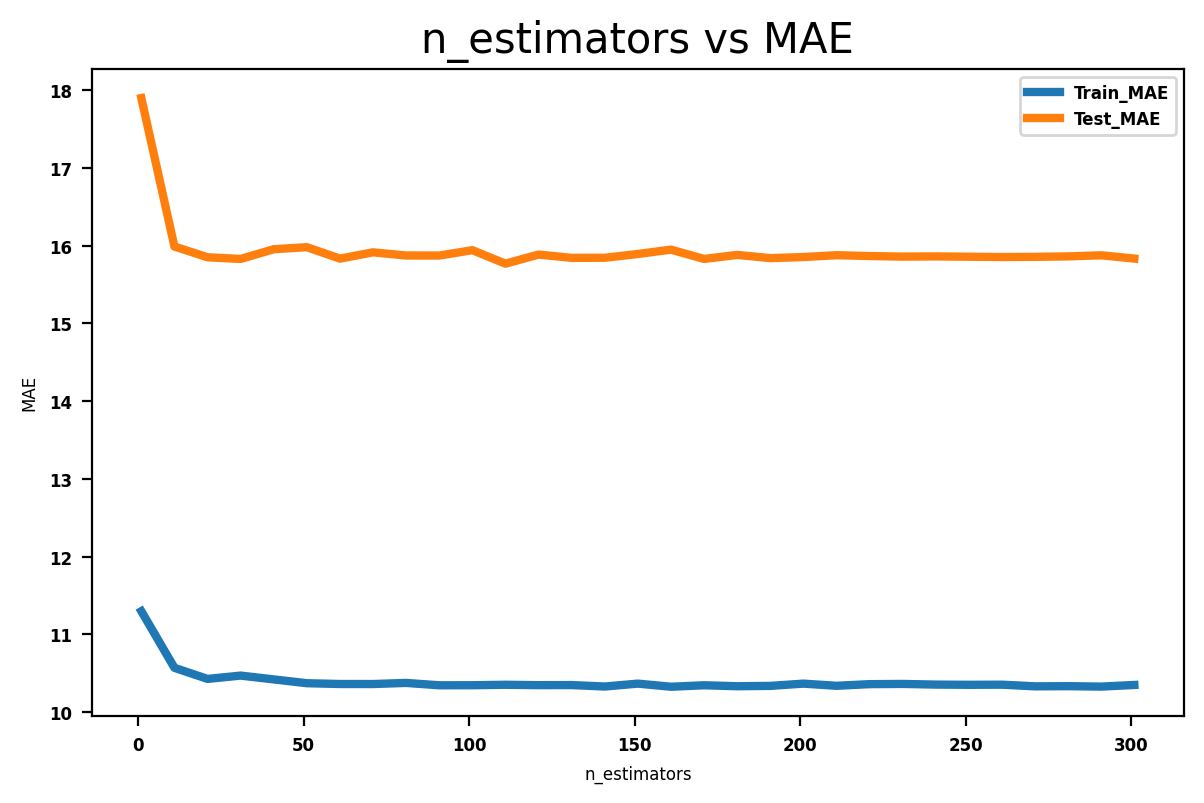

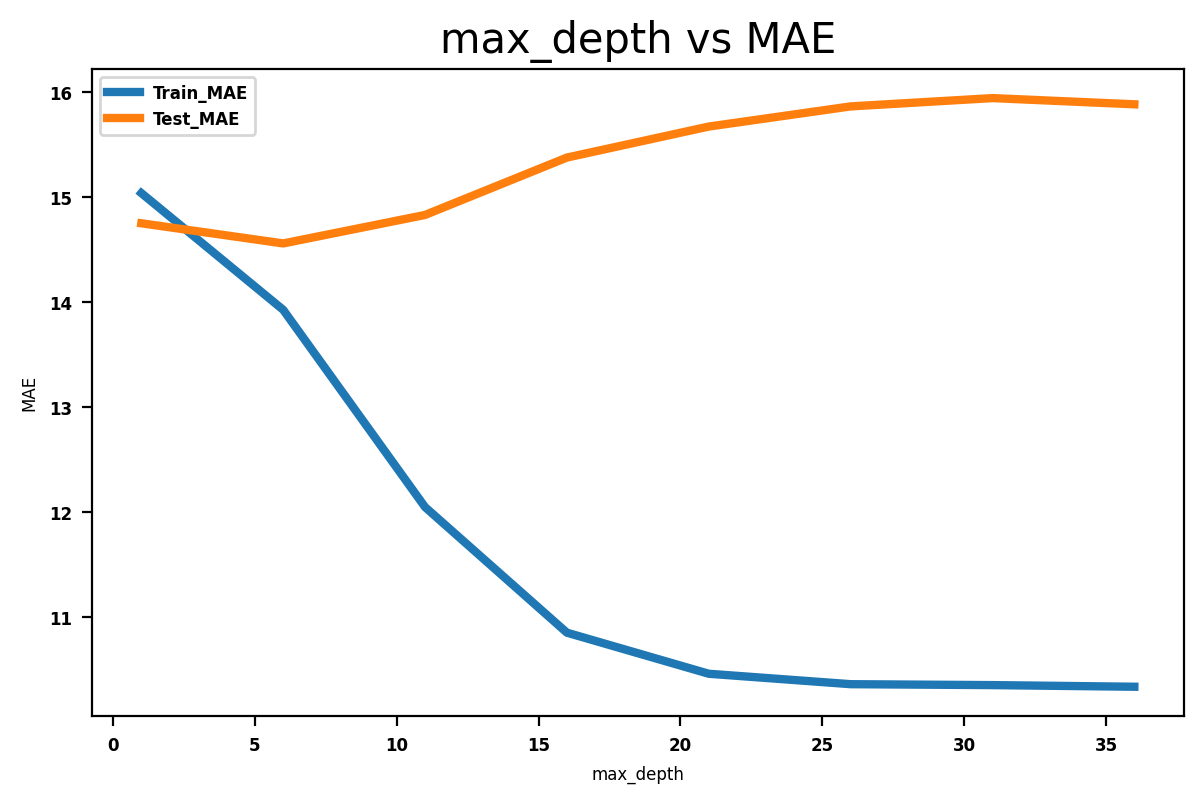

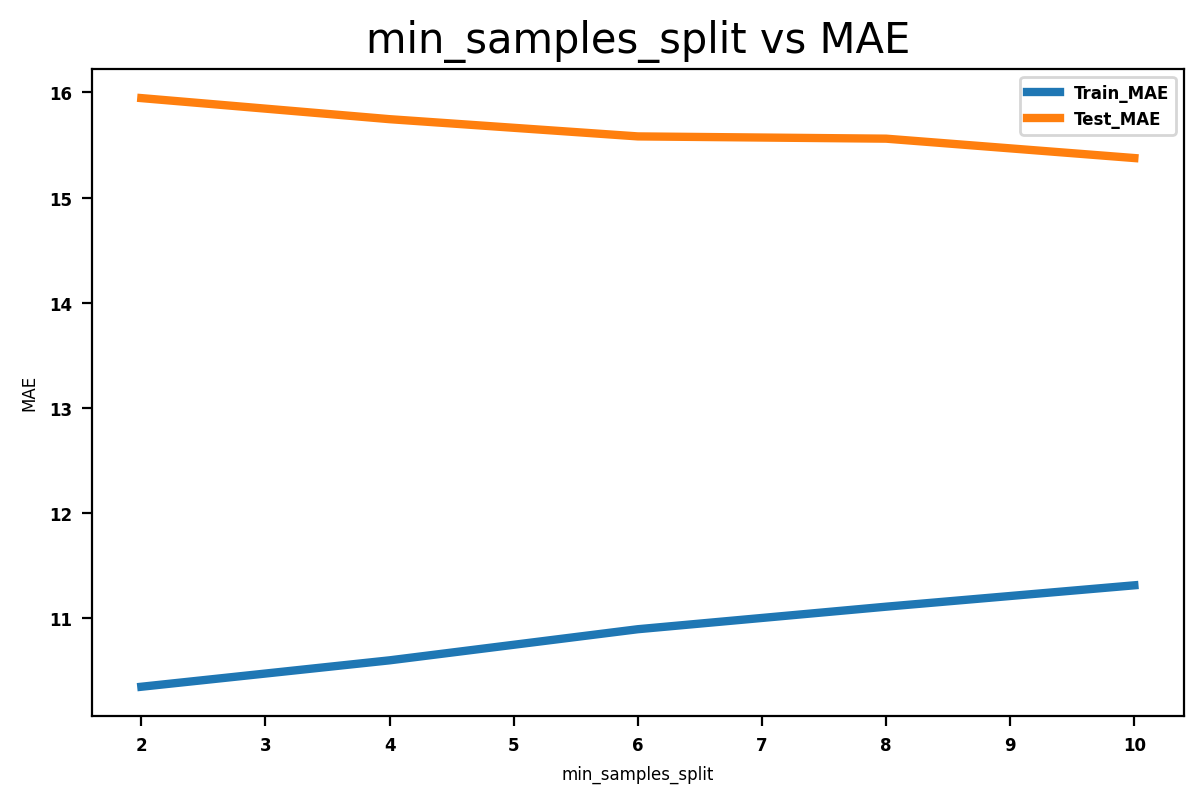

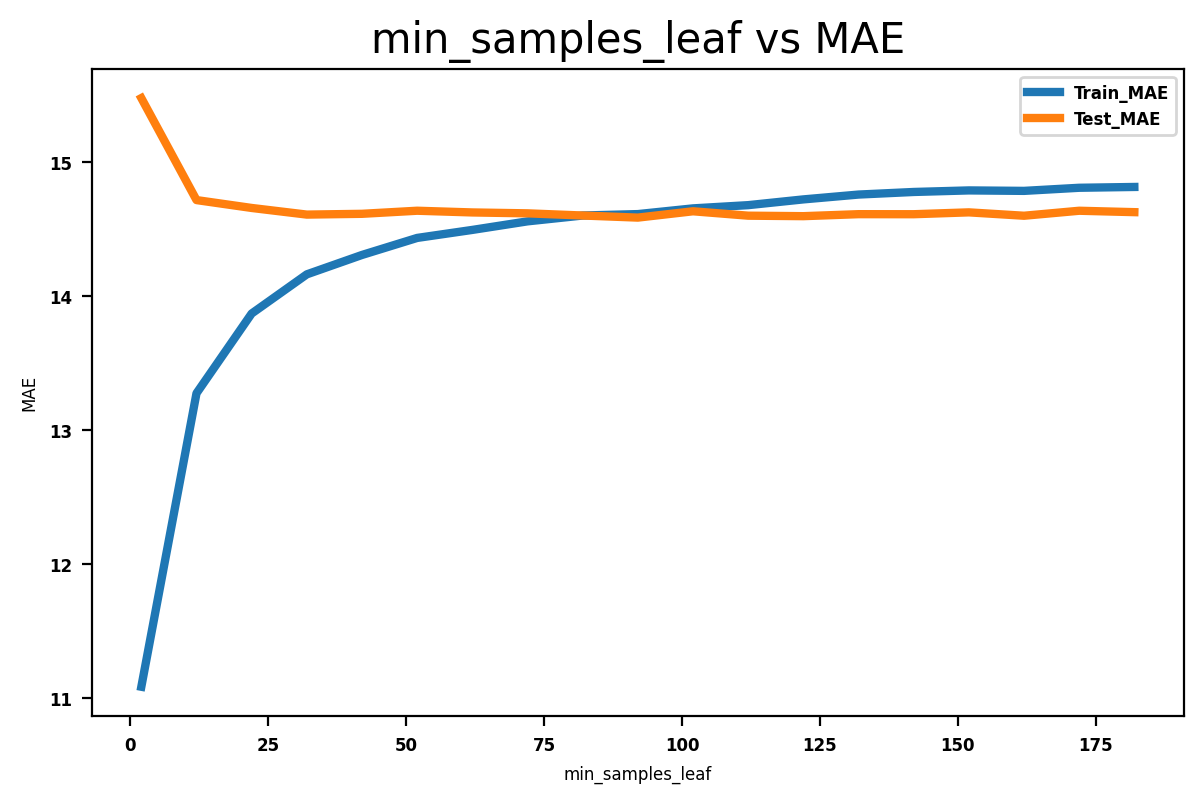

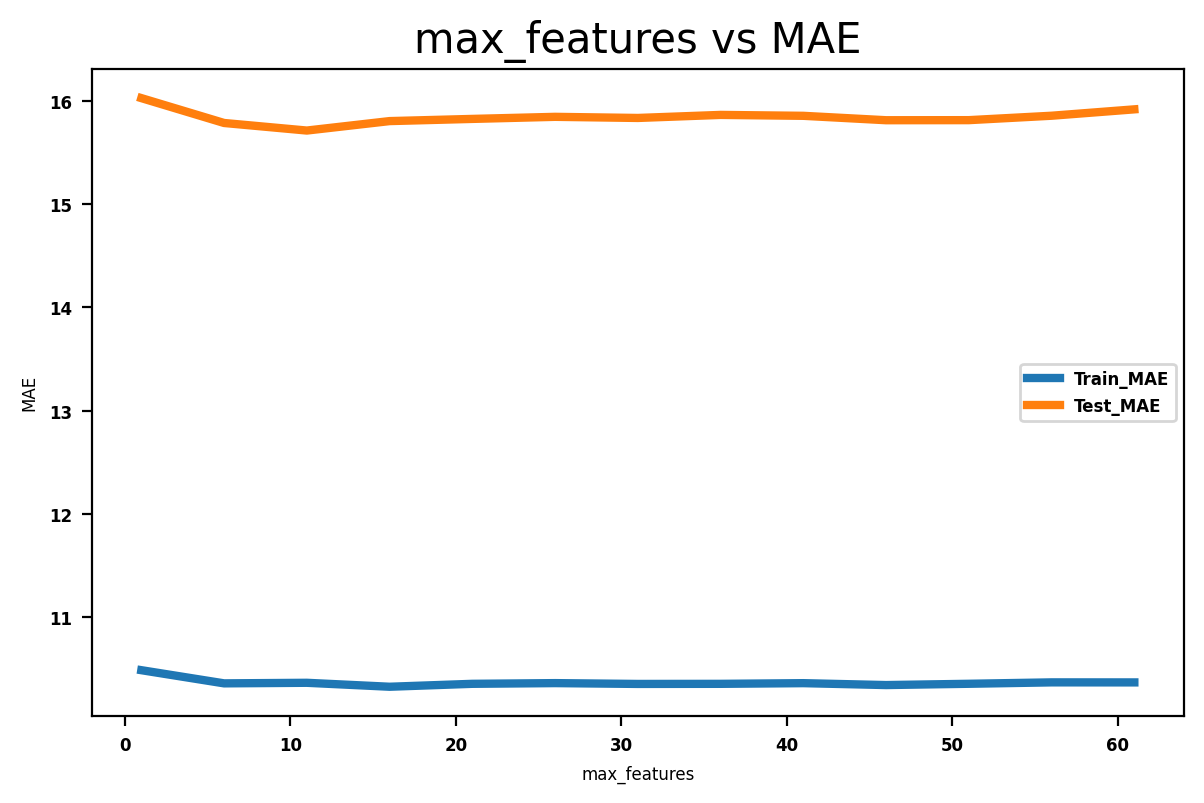

In [346]:
features = {'n_estimators': [1, 310, 10], 
            'max_depth': [1, 41, 5],
            'min_samples_split': [2, 11, 2],
            'min_samples_leaf': [2, 190, 10],
            'max_features': [1, 65, 5]}
for feature in features:
    find_best_rf_feature_val(X_train_encoded, X_test_encoded, y_train, y_test, feature=feature, feature_range_base=features[feature][0], feature_range=features[feature][1], feature_increment=features[feature][2])

In [347]:
features = {'n_estimators': [1, 310, 10], 
            'max_depth': [1, 41, 5],
            'min_samples_split': [2, 11, 2],
            'min_samples_leaf': [2, 190, 10],
            'max_features': [1, 65, 5]}

In [348]:
train_scores, test_scores = validation_curve(estimator=RandomForestRegressor(), X=X_train_encoded, y=y_train, param_name='n_estimators', param_range=[1, 310, 10], cv=5, scoring='neg_mean_absolute_error')

Ballpark Best Feature Values:

    - n_estimators = 171
    - max_depth = 6
    - min_samples_split = 10
    - min_samples_leaf = 102
    - max_features = 61
    - n_jobs = -1 -> use all processors

In [349]:
# parameters = {'n_estimators': [i for i in range(20, 181, 10)], 
#             'max_depth': [i for i in range(4, 9, 1)],
#             'min_samples_split': [i for i in range(2, 15, 3)],
#             'min_samples_leaf': [i for i in range(25, 110, 10)],
#             'max_features': [i for i in range(5, 63, 10)]}
# grid = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [350]:
# grid.fit(X_train_encoded, y_train)

In [351]:
# grid.best_score_
# -17.485168039847373
# -17.48650961540202
# -17.490051012317803
# -14.60759245710237

In [352]:
# grid.best_estimator_
# best
    # RandomForestRegressor(max_depth=8, max_features=45, min_samples_leaf=35,
    #                       min_samples_split=100, n_estimators=165)
# RandomForestRegressor(max_depth=7, max_features=50, min_samples_leaf=45,
#                       min_samples_split=11, n_estimators=165)
# RandomForestRegressor(max_depth=7, max_features=45, min_samples_leaf=35,
                    #   min_samples_split=5, n_estimators=20)

In [353]:
# 14.60759245710237 best score

In [377]:
best_rf = RandomForestRegressor(max_depth=8, max_features=45, min_samples_leaf=35, min_samples_split=100, n_estimators=165)
best_rf.fit(X_train_encoded, y_train)
y_pred = best_rf.predict(X_test_encoded)
mean_absolute_error(y_test, y_pred)

14.586430882685281

In [355]:
# parameters = {'n_estimators': [i for i in range(160, 170, 1)], 
#             'max_depth': [i for i in range(6, 10, 1)],
#             'min_samples_split': [i for i in range(100, 105, 1)],
#             'min_samples_leaf': [i for i in range(32, 37, 1)],
#             'max_features': [i for i in range(42, 47, 1)]}
# grid = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [356]:
# grid.fit(X_train_encoded, y_train)

In [357]:
# grid.best_score_

### Scikit Validation Curves

In [358]:
features = {'n_estimators': np.arange(1, 310, 30), 
            'max_depth': np.arange(1, 41, 5),
            'min_samples_split': np.arange(2, 11, 2),
            'min_samples_leaf': np.arange(2, 190, 10),
            'max_features': np.arange(1, 65, 5)}

In [359]:
def sklearn_validation_curves(parameter_name, parameter_range):
    '''
    Uses sklearn's validation curve method. Plots validation curves.
    '''
    train_scores, test_scores = validation_curve(RandomForestRegressor(), X_train_encoded, y_train, param_name=parameter_name, param_range=parameter_range, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
    mean_train_scores = [-1 * np.mean(scores) for scores in train_scores]
    mean_test_scores = [-1 * np.mean(scores) for scores in test_scores]
    fig = plt.figure(figsize=(6,4))
    ax = fig.subplots()
    ax.plot(parameter_range, mean_train_scores, linewidth=3 ,alpha=1,label='Train_MAE')
    ax.plot(parameter_range, mean_test_scores, linewidth=3 ,alpha=1,label='Test_MAE')
    ax.set_title('%s vs MAE' %(parameter_name), fontsize=15)
    ax.set_xlabel('%s' %(parameter_name))
    ax.set_ylabel('MAE')
    ax.legend()
    plt.tight_layout()
    plt.show
    min_index = mean_test_scores.index(min(mean_test_scores))
    print('%s Value for Lowest MAE Test: ' %(feature), parameter_range[min_index])
    print('Lowest MAE Score for Test: ', mean_test_scores[min_index])
    print('Corresponding MAE Score for Train: ', mean_train_scores[min_index])
    print()

n_estimators Value for Lowest MAE Test:  301
Lowest MAE Score for Test:  16.0811080173676
Corresponding MAE Score for Train:  9.98489335953408

max_depth Value for Lowest MAE Test:  6
Lowest MAE Score for Test:  14.934959216476695
Corresponding MAE Score for Train:  13.804811723885617

min_samples_split Value for Lowest MAE Test:  10
Lowest MAE Score for Test:  15.68020033180279
Corresponding MAE Score for Train:  11.11286495561562

min_samples_leaf Value for Lowest MAE Test:  72
Lowest MAE Score for Test:  14.9315296677489
Corresponding MAE Score for Train:  14.565800025343222

max_features Value for Lowest MAE Test:  61
Lowest MAE Score for Test:  16.060744884703084
Corresponding MAE Score for Train:  10.005945109068414



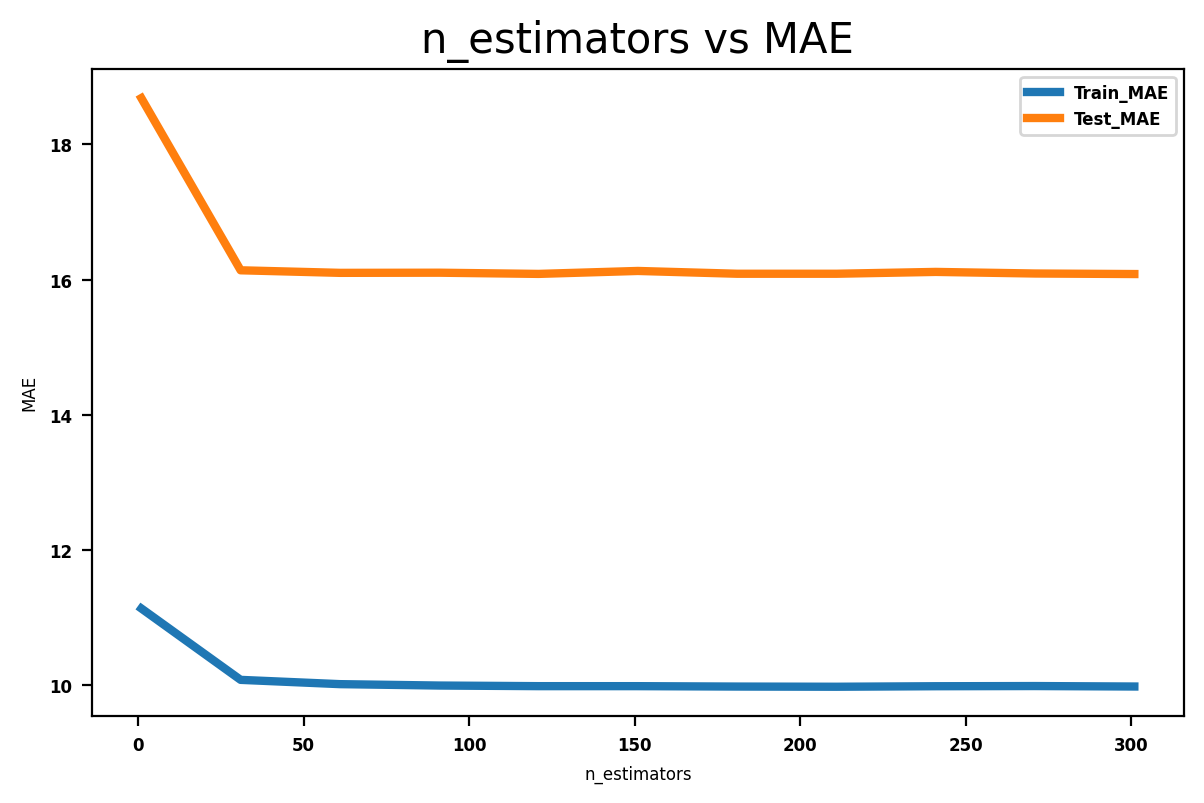

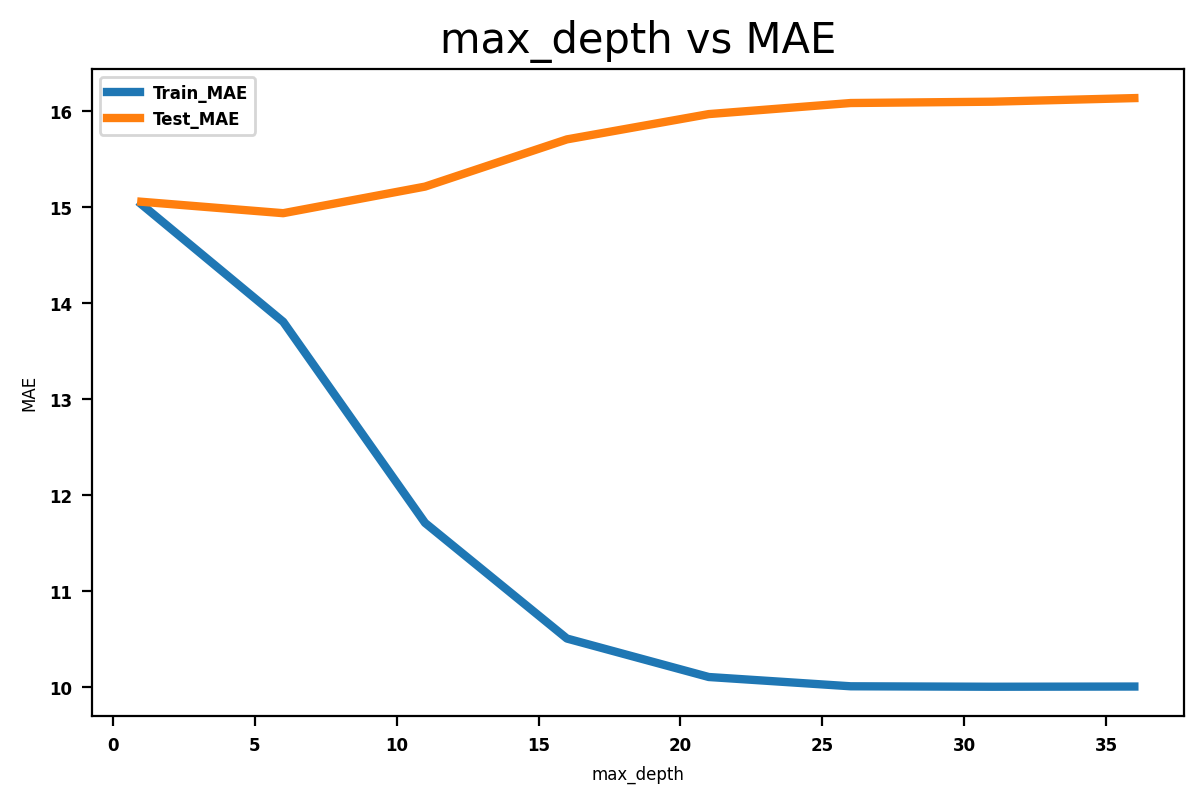

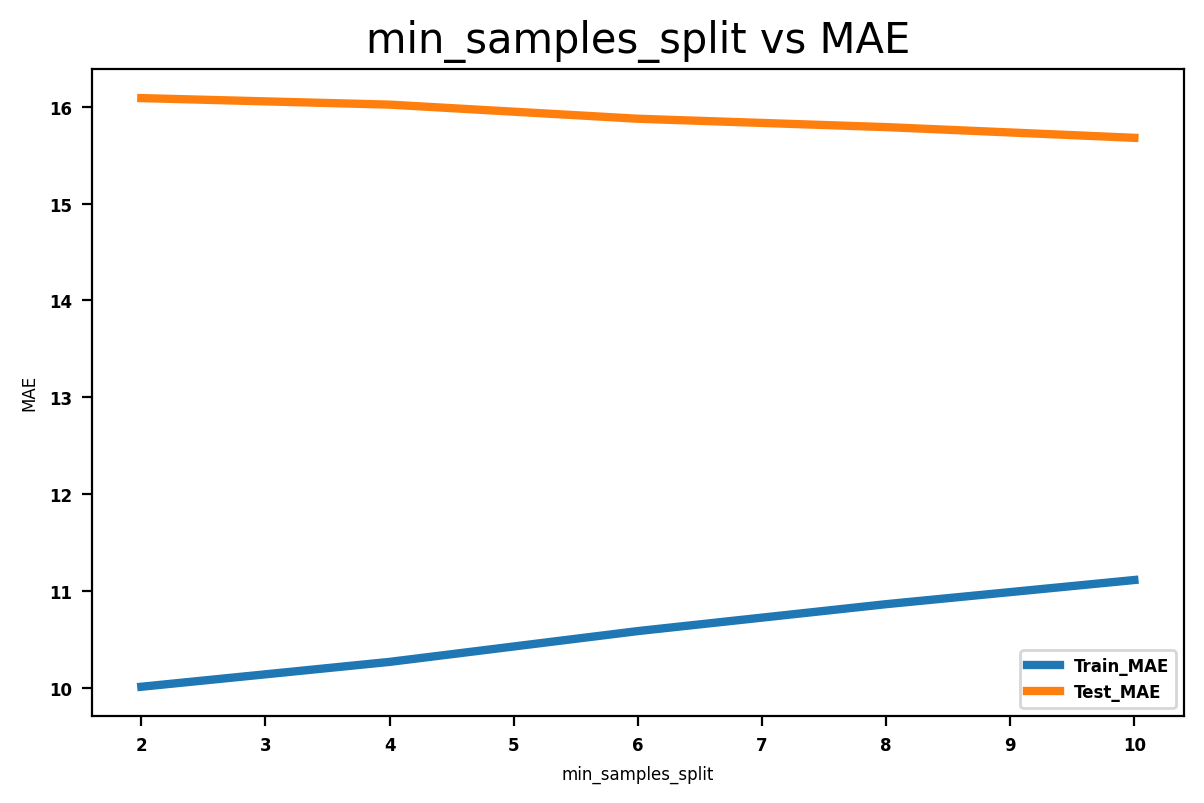

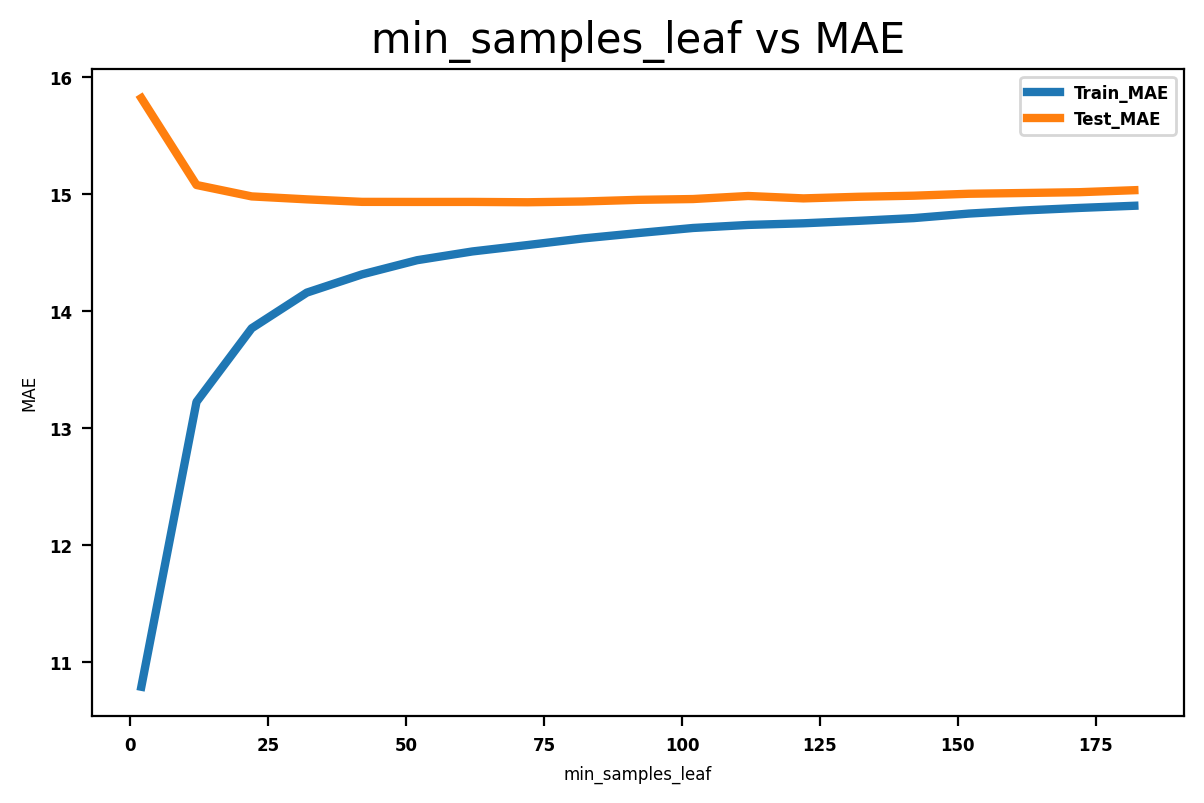

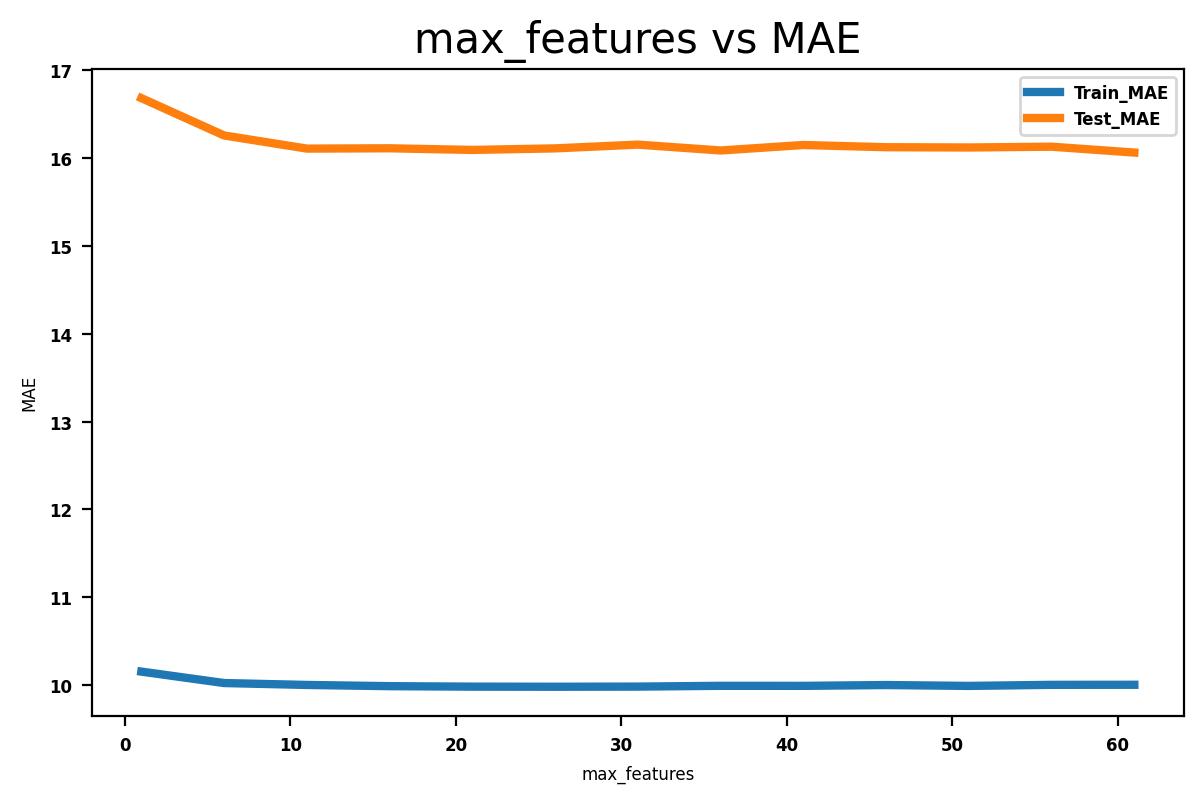

In [360]:
for feature in features:
    sklearn_validation_curves(feature, features[feature])

# Random Forest Feature Selection

In [361]:
rf_reg = RandomForestRegressor(max_depth=8, max_features=45, min_samples_leaf=35, min_samples_split=100, n_estimators=165)

In [362]:
rfe_rf = RFECV(estimator=RandomForestRegressor(max_depth=8, max_features=0.70, min_samples_leaf=35, min_samples_split=100, n_estimators=165), min_features_to_select=1,scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [363]:
rfe_rf.fit(X_train_encoded, y_train)

RFECV(cv=5,
      estimator=RandomForestRegressor(max_depth=8, max_features=0.7,
                                      min_samples_leaf=35,
                                      min_samples_split=100, n_estimators=165),
      n_jobs=-1, scoring='neg_mean_absolute_error')

In [364]:
print('The optimal number features to select is: ', rfe_rf.n_features_)
optimal_features = list(rfe_rf.get_feature_names_out(X_train_encoded.columns))

The optimal number features to select is:  53


In [365]:
best_rf = RandomForestRegressor(max_depth=8, max_features=0.70, min_samples_leaf=35, min_samples_split=100, n_estimators=165)
best_rf.fit(X_train_encoded[optimal_features], y_train)
y_pred = best_rf.predict(X_test_encoded[optimal_features])
mean_absolute_error(y_test, y_pred)

14.58579590041572

In [366]:
optimal_features

['Company Size_10000+ Employees',
 'Company Size_1001 to 5000 Employees',
 'Company Size_201 to 500 Employees',
 'Company Size_5001 to 10000 Employees',
 'Company Size_501 to 1000 Employees',
 'Company Size_51 to 200 Employees',
 'Company Size_Unknown',
 'Company Type_Company - Public',
 'Company Type_Other',
 'Company Revenue_$1 to $5 million (USD)',
 'Company Revenue_$10+ billion (USD)',
 'Company Revenue_$100 to $500 million (USD)',
 'Company Revenue_$2 to $5 billion (USD)',
 'Company Revenue_$25 to $50 million (USD)',
 'Company Revenue_$5 to $10 billion (USD)',
 'Company Revenue_$500 million to $1 billion (USD)',
 'Company Revenue_Unknown / Non-Applicable',
 'Job State_Northeast',
 'Job State_Remote/Other',
 'Job State_South',
 'Job State_Southwest',
 'Job State_West',
 'Education Demanded_No Higher Education',
 'Job Level_Experienced',
 'Job Level_Other',
 'Job Label_Data Scientist',
 'Job Label_Machine Learning Engineer',
 'Job Label_Other',
 'Grouped Company Industry_Constructio

In [367]:
# num_features = []
# best_mae = np.inf
# for i in range(20, len(X_train_encoded.columns)):
#     num_features.append(i)
#     rfe = RFECV(estimator=RandomForestRegressor(max_depth=8, max_features=45, min_samples_leaf=35, min_samples_split=100, n_estimators=165), min_features_to_select=i, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
#     rfe.fit(X_train_encoded, y_train)

# Quick Exploration Multicollinearity

In [368]:
# plt.figure(figsize=(20,15))
# sns.heatmap(X_train_encoded.corr(), cmap='viridis', linecolor='black', linewidth=2)

In [369]:
# # Produce a DataFrame of correlations for a more accurate evaluation of features
# def get_correlation_df(df, bound):
#     '''
#     Creates a DataFrame representation of correlation values, sorted.
#     '''
#     dfCorr = df.corr()
#     filteredDf = dfCorr[((abs(dfCorr)) >= bound) & (dfCorr != 1.000)]
#     flattenedCorr = filteredDf.unstack().sort_values().drop_duplicates()
#     plt.figure(figsize=(30,10))
#     sns.heatmap(filteredDf, annot=True, cmap="Reds")
#     plt.show()

#     return flattenedCorr

In [370]:
# flattened = get_correlation_df(X_train_encoded, 0.7)

In [371]:
# flattened

In [372]:
# def removeMultiColl(df, vif_threshold = 5.0):
#     '''
#     Finds variables exhibiting high VIF (default threshold 5.0) and drops said variables.
#     '''
#     for i in df.columns:  # Handling cols with 1 unique value. VIF for these columns is non-finite or NaN. Cols with single unique value may impose biased in system.
#         if df[i].nunique() == 1:
#             print(f"Dropping {i} due to just 1 unique value")
#             df.drop(columns = i, inplace = True)
#     drop = True
#     col_list = list(df.columns)
#     while drop == True:  # While any feature still exhibits VIF higher than threshold, drop feature
#         drop = False
#         vif_list = Parallel(n_jobs = -1, verbose = 5)(delayed(variance_inflation_factor)(df[col_list].values, i) for i in range(df[col_list].shape[1]))
#         max_index = vif_list.index(max(vif_list))
#         if vif_list[max_index] > vif_threshold:
#             print(f"Dropping column : {col_list[max_index]} at index - {max_index}")
#             del col_list[max_index]
#             drop = True
#     print("Remaining columns :\n", list(df[col_list].columns))
#     return df[col_list]

In [373]:
# X_train_encoded_2 = removeMultiColl(X_train_encoded, 5)